In [91]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [92]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=2
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [93]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [94]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [95]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [96]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [97]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [98]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [99]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [100]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [101]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [102]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [103]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


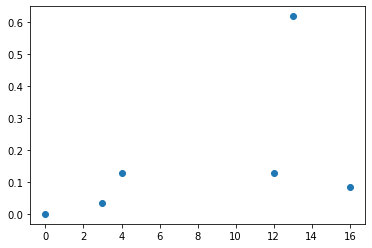

In [104]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [105]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [106]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [140]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        

    return swap_matrix


def exp_gate(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)

    if k == 2:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3))
    if k == 0:
        Matrix_full = scipy.sparse.kron(sparse.identity(3),Matrix)
    if k == 1:
        Matrix_full = swap(1,2)@scipy.sparse.kron(Matrix,sparse.identity(3))@swap(1,2)
    return Matrix_full.toarray()


In [141]:
def exp_gate_der(k,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2

    if k == 2:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3))
    if k == 0:
        Matrix_full = scipy.sparse.kron(sparse.identity(3),Matrix)
    if k == 1:
        Matrix_full = swap(1,2)@scipy.sparse.kron(Matrix,sparse.identity(3))@swap(1,2)
    return Matrix_full.toarray()




In [142]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [143]:
print(np.allclose(np.identity(basis.Ns),exp_gate(0,np.pi/3).conj().T@exp_gate(0,np.pi/3),atol = 1e-8,rtol= 1e-8))

True


/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [144]:
def R(i,theta):
    
    if i%9 == 0:
        return(exp_gate(0,theta))

    if i%9 == 1:
        return(exp_gate(1,theta))

    if i%9 == 2:
        return(exp_gate(2,theta))

    
    if i%9 == 3:
        return(rot_sigma_o(0,1,0,theta).toarray())


    if i%9 == 4:
        return(rot_sigma_o(0,2,0,theta).toarray())

    
    if i%9 == 5:
        return(rot_sigma_o(1,2,np.pi/2,theta).toarray())

    if i%9 == 6:
        return(rot_sigma_r(0,1,0,theta).toarray())


    if i%9 == 7:
        return(rot_sigma_r(0,2,0,theta).toarray())

    
    if i%9 == 8:
        return(rot_sigma_r(1,2,np.pi/2,theta).toarray())
        

def S(i,theta):
    
    if i%9 == 0:
        return(exp_gate_der(0,theta)@exp_gate(0,theta).T.conj())

    if i%9 == 1:
        return(exp_gate_der(1,theta)@exp_gate(1,theta).T.conj())
    
    if i%9 == 2:
        return(exp_gate_der(2,theta)@exp_gate(2,theta).T.conj())
     
    if i%9 == 3:
        return(-1j*sigma_o(0,1,0).toarray())

    
    if i%9 == 4:
        return(-1j*sigma_o(0,2,0).toarray())

    
    if i%9 == 5:
        return(-1j*sigma_o(1,2,np.pi/2).toarray())

     
    if i%9 == 6:
        return(-1j*sigma_r(0,1,0).toarray())

    
    if i%9 == 7:
        return(-1j*sigma_r(0,2,0).toarray())
    

    if i%9 == 8:
        return(-1j*sigma_r(1,2,np.pi/2).toarray())

In [145]:
coeff = 9
stepp = 2000
t_final = 5

In [146]:
matr = full_ham_matrix.toarray()
B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

In [147]:
def rhs(t,theta):
    
    print(datetime.datetime.now())
    for k in range(coeff*N):
        B[k] = R(k,theta[k])
        
    psi_b = psi_0
    for k in range(coeff*N):
        psi_b = B[coeff*N-1-k]@psi_b
        
    psi_conj_b = np.conj(psi_b)

    print("start",datetime.datetime.now())
    
    for k in range(coeff*N):
        B[k] = S(k,theta[k])@R(k,theta[k])
        psi_d[k] = psi_0
        for i in range(coeff*N):
            psi_d[k] = B[coeff*N-1-i]@psi_d[k]
        B[k] = R(k,theta[k])
        
    print("stop_reduce",datetime.datetime.now())
    
    psi_conj_d = np.conj(psi_d)
    


    
    X = np.zeros((coeff*N,coeff*N),dtype = complex)
    Y = np.zeros(coeff*N,dtype = complex)


    X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

    Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)
    
    XX = np.einsum("il,l->i",psi_conj_d,psi_b)
    
    YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)
        
    YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
    YY = YY_1*YY_2
    XX = np.outer(XX,XX)
    X_r = 2*np.real(X+XX)
    Y_i = 2*np.real(Y+YY)
    result = -np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
    print(datetime.datetime.now())

    print(t)

    return result

In [148]:
time_domain = np.linspace(0, t_final, stepp)


In [149]:
# RK-4 method
def rk4(x0,y0,xn,n):
    global Y

    # Calculating step size
    h = (xn-x0)/n

    #print('\n--------SOLUTION--------')
    #print('-------------------------')    
    #print('x0\ty0\tyn')
    #print('-------------------------')
    for i in range(n):
        k1 = h * (rhs(x0, y0))
        k2 = h * (rhs((x0+h/2), (y0+k1/2)))
        k3 = h * (rhs((x0+h/2), (y0+k2/2)))
        k4 = h * (rhs((x0+h), (y0+k3)))
        k = (k1+2*k2+2*k3+k4)/6
        yn = y0 + k
        #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
        #print('-------------------------')
        y0 = yn
        x0 = x0+h
        Y.append(y0)
    
    #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

# Inputs
#print('Enter initial conditions:')
#x0 = float(input('x0 = '))
#y0 = float(input('y0 = '))

#print('Enter calculation point: ')
#xn = float(input('xn = '))

#print('Enter number of steps:')
#step = int(input('Number of steps = '))

# RK4 method call


In [150]:
#start_point = 0.001*np.ones(coeff*N)
expt_value = []
energyy = []

for kkk in range(1):
    Y = []
    start_point = np.random.rand(coeff*N)
    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi

        return psi
    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))
    energy = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])

        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.abs(np.conj(psi_var)@psi_ground/norm)**2
        energy[tt] = np.real(np.conj(psi_var)@full_ham_matrix@psi_var/norm**2)
        
    expt_value.append(expt_value_u)
    energyy.append(energy)


    

2022-08-11 12:40:16.460150
start 2022-08-11 12:40:16.546824
stop_reduce 2022-08-11 12:40:16.813344
2022-08-11 12:40:16.814212
0
2022-08-11 12:40:16.814257
start 2022-08-11 12:40:16.897073
stop_reduce 2022-08-11 12:40:17.142665
2022-08-11 12:40:17.143406
0.005
2022-08-11 12:40:17.143536
start 2022-08-11 12:40:17.229953
stop_reduce 2022-08-11 12:40:17.474108
2022-08-11 12:40:17.474866
0.005
2022-08-11 12:40:17.474918
start 2022-08-11 12:40:17.561720
stop_reduce 2022-08-11 12:40:17.805878
2022-08-11 12:40:17.806851
0.01
2022-08-11 12:40:17.806904
start 2022-08-11 12:40:17.889535
stop_reduce 2022-08-11 12:40:18.134047
2022-08-11 12:40:18.134793
0.01
2022-08-11 12:40:18.134957
start 2022-08-11 12:40:18.217782
stop_reduce 2022-08-11 12:40:18.461515
2022-08-11 12:40:18.462359
0.015
2022-08-11 12:40:18.462406
start 2022-08-11 12:40:18.557106
stop_reduce 2022-08-11 12:40:18.801477
2022-08-11 12:40:18.802258
0.015
2022-08-11 12:40:18.802385
start 2022-08-11 12:40:18.885415
stop_reduce 2022-08-11

stop_reduce 2022-08-11 12:40:37.692619
2022-08-11 12:40:37.693286
0.15
2022-08-11 12:40:37.693333
start 2022-08-11 12:40:37.776182
stop_reduce 2022-08-11 12:40:38.017313
2022-08-11 12:40:38.018045
0.155
2022-08-11 12:40:38.018095
start 2022-08-11 12:40:38.107667
stop_reduce 2022-08-11 12:40:38.350048
2022-08-11 12:40:38.350821
0.155
2022-08-11 12:40:38.350994
start 2022-08-11 12:40:38.433476
stop_reduce 2022-08-11 12:40:38.676193
2022-08-11 12:40:38.676838
0.16
2022-08-11 12:40:38.676907
start 2022-08-11 12:40:38.761190
stop_reduce 2022-08-11 12:40:39.002912
2022-08-11 12:40:39.003643
0.16
2022-08-11 12:40:39.003774
start 2022-08-11 12:40:39.093489
stop_reduce 2022-08-11 12:40:39.335710
2022-08-11 12:40:39.336359
0.165
2022-08-11 12:40:39.336426
start 2022-08-11 12:40:39.419165
stop_reduce 2022-08-11 12:40:39.660797
2022-08-11 12:40:39.661435
0.165
2022-08-11 12:40:39.661495
start 2022-08-11 12:40:39.744496
stop_reduce 2022-08-11 12:40:39.987106
2022-08-11 12:40:39.987842
0.17
2022-08-

stop_reduce 2022-08-11 12:40:56.810818
2022-08-11 12:40:56.811568
0.2950000000000001
2022-08-11 12:40:56.811621
start 2022-08-11 12:40:56.894164
stop_reduce 2022-08-11 12:40:57.134431
2022-08-11 12:40:57.135149
0.3000000000000001
2022-08-11 12:40:57.135274
start 2022-08-11 12:40:57.217524
stop_reduce 2022-08-11 12:40:57.469323
2022-08-11 12:40:57.470033
0.3000000000000001
2022-08-11 12:40:57.470158
start 2022-08-11 12:40:57.552431
stop_reduce 2022-08-11 12:40:57.792736
2022-08-11 12:40:57.793453
0.3050000000000001
2022-08-11 12:40:57.793502
start 2022-08-11 12:40:57.878515
stop_reduce 2022-08-11 12:40:58.119383
2022-08-11 12:40:58.120116
0.3050000000000001
2022-08-11 12:40:58.120290
start 2022-08-11 12:40:58.202592
stop_reduce 2022-08-11 12:40:58.447513
2022-08-11 12:40:58.448270
0.3100000000000001
2022-08-11 12:40:58.448323
start 2022-08-11 12:40:58.531008
stop_reduce 2022-08-11 12:40:58.772446
2022-08-11 12:40:58.773144
0.3100000000000001
2022-08-11 12:40:58.773196
start 2022-08-11 1

stop_reduce 2022-08-11 12:41:15.691857
2022-08-11 12:41:15.692677
0.4400000000000002
2022-08-11 12:41:15.692739
start 2022-08-11 12:41:15.780461
stop_reduce 2022-08-11 12:41:16.040029
2022-08-11 12:41:16.040844
0.4400000000000002
2022-08-11 12:41:16.040902
start 2022-08-11 12:41:16.128302
stop_reduce 2022-08-11 12:41:16.383124
2022-08-11 12:41:16.383807
0.44500000000000023
2022-08-11 12:41:16.383858
start 2022-08-11 12:41:16.471682
stop_reduce 2022-08-11 12:41:16.728298
2022-08-11 12:41:16.729105
0.44500000000000023
2022-08-11 12:41:16.729304
start 2022-08-11 12:41:16.816867
stop_reduce 2022-08-11 12:41:17.072478
2022-08-11 12:41:17.073264
0.45000000000000023
2022-08-11 12:41:17.073471
start 2022-08-11 12:41:17.161178
stop_reduce 2022-08-11 12:41:17.413296
2022-08-11 12:41:17.414059
0.45000000000000023
2022-08-11 12:41:17.414116
start 2022-08-11 12:41:17.502735
stop_reduce 2022-08-11 12:41:17.760729
2022-08-11 12:41:17.761552
0.45500000000000024
2022-08-11 12:41:17.761741
start 2022-08

stop_reduce 2022-08-11 12:41:36.408252
2022-08-11 12:41:36.409083
0.5800000000000003
2022-08-11 12:41:36.409150
start 2022-08-11 12:41:36.506313
stop_reduce 2022-08-11 12:41:36.792221
2022-08-11 12:41:36.793034
0.5850000000000003
2022-08-11 12:41:36.793093
start 2022-08-11 12:41:36.896551
stop_reduce 2022-08-11 12:41:37.179496
2022-08-11 12:41:37.180337
0.5850000000000003
2022-08-11 12:41:37.180398
start 2022-08-11 12:41:37.277537
stop_reduce 2022-08-11 12:41:37.559891
2022-08-11 12:41:37.560637
0.5900000000000003
2022-08-11 12:41:37.560697
start 2022-08-11 12:41:37.658823
stop_reduce 2022-08-11 12:41:37.945921
2022-08-11 12:41:37.946751
0.5900000000000003
2022-08-11 12:41:37.946812
start 2022-08-11 12:41:38.044315
stop_reduce 2022-08-11 12:41:38.329184
2022-08-11 12:41:38.329992
0.5950000000000003
2022-08-11 12:41:38.330054
start 2022-08-11 12:41:38.429047
stop_reduce 2022-08-11 12:41:38.712017
2022-08-11 12:41:38.712856
0.5950000000000003
2022-08-11 12:41:38.712906
start 2022-08-11 1

stop_reduce 2022-08-11 12:41:58.320067
2022-08-11 12:41:58.320896
0.7250000000000004
2022-08-11 12:41:58.320958
start 2022-08-11 12:41:58.418047
stop_reduce 2022-08-11 12:41:58.701388
2022-08-11 12:41:58.702247
0.7250000000000004
2022-08-11 12:41:58.702305
start 2022-08-11 12:41:58.801374
stop_reduce 2022-08-11 12:41:59.095170
2022-08-11 12:41:59.095982
0.7300000000000004
2022-08-11 12:41:59.096053
start 2022-08-11 12:41:59.191985
stop_reduce 2022-08-11 12:41:59.473164
2022-08-11 12:41:59.473993
0.7300000000000004
2022-08-11 12:41:59.474056
start 2022-08-11 12:41:59.570087
stop_reduce 2022-08-11 12:41:59.852010
2022-08-11 12:41:59.852835
0.7350000000000004
2022-08-11 12:41:59.852908
start 2022-08-11 12:41:59.950529
stop_reduce 2022-08-11 12:42:00.242367
2022-08-11 12:42:00.243188
0.7350000000000004
2022-08-11 12:42:00.243248
start 2022-08-11 12:42:00.339695
stop_reduce 2022-08-11 12:42:00.624420
2022-08-11 12:42:00.625256
0.7400000000000004
2022-08-11 12:42:00.625322
start 2022-08-11 1

stop_reduce 2022-08-11 12:42:20.240385
2022-08-11 12:42:20.241213
0.8650000000000005
2022-08-11 12:42:20.241272
start 2022-08-11 12:42:20.337205
stop_reduce 2022-08-11 12:42:20.626110
2022-08-11 12:42:20.626914
0.8700000000000006
2022-08-11 12:42:20.627128
start 2022-08-11 12:42:20.723150
stop_reduce 2022-08-11 12:42:21.002552
2022-08-11 12:42:21.003403
0.8700000000000006
2022-08-11 12:42:21.003459
start 2022-08-11 12:42:21.101781
stop_reduce 2022-08-11 12:42:21.386846
2022-08-11 12:42:21.387677
0.8750000000000006
2022-08-11 12:42:21.387738
start 2022-08-11 12:42:21.484479
stop_reduce 2022-08-11 12:42:21.769523
2022-08-11 12:42:21.770309
0.8750000000000006
2022-08-11 12:42:21.770366
start 2022-08-11 12:42:21.867097
stop_reduce 2022-08-11 12:42:22.147352
2022-08-11 12:42:22.148170
0.8800000000000006
2022-08-11 12:42:22.148231
start 2022-08-11 12:42:22.244988
stop_reduce 2022-08-11 12:42:22.530468
2022-08-11 12:42:22.531278
0.8800000000000006
2022-08-11 12:42:22.531342
start 2022-08-11 1

stop_reduce 2022-08-11 12:42:43.021296
2022-08-11 12:42:43.022209
1.0100000000000007
2022-08-11 12:42:43.022273
start 2022-08-11 12:42:43.129583
stop_reduce 2022-08-11 12:42:43.454963
2022-08-11 12:42:43.455778
1.0100000000000007
2022-08-11 12:42:43.455847
start 2022-08-11 12:42:43.571482
stop_reduce 2022-08-11 12:42:43.926028
2022-08-11 12:42:43.926928
1.0150000000000006
2022-08-11 12:42:43.927002
start 2022-08-11 12:42:44.037773
stop_reduce 2022-08-11 12:42:44.367836
2022-08-11 12:42:44.368630
1.0150000000000006
2022-08-11 12:42:44.368716
start 2022-08-11 12:42:44.481257
stop_reduce 2022-08-11 12:42:44.799952
2022-08-11 12:42:44.800807
1.0200000000000007
2022-08-11 12:42:44.800877
start 2022-08-11 12:42:44.908334
stop_reduce 2022-08-11 12:42:45.211406
2022-08-11 12:42:45.212261
1.0200000000000007
2022-08-11 12:42:45.212323
start 2022-08-11 12:42:45.315971
stop_reduce 2022-08-11 12:42:45.608899
2022-08-11 12:42:45.609767
1.0250000000000006
2022-08-11 12:42:45.609825
start 2022-08-11 1

stop_reduce 2022-08-11 12:43:07.405974
2022-08-11 12:43:07.406787
1.1500000000000008
2022-08-11 12:43:07.406846
start 2022-08-11 12:43:07.509972
stop_reduce 2022-08-11 12:43:07.811943
2022-08-11 12:43:07.812844
1.1550000000000007
2022-08-11 12:43:07.813037
start 2022-08-11 12:43:07.916772
stop_reduce 2022-08-11 12:43:08.208264
2022-08-11 12:43:08.209128
1.1550000000000007
2022-08-11 12:43:08.209337
start 2022-08-11 12:43:08.307837
stop_reduce 2022-08-11 12:43:08.607052
2022-08-11 12:43:08.607929
1.1600000000000008
2022-08-11 12:43:08.608000
start 2022-08-11 12:43:08.723661
stop_reduce 2022-08-11 12:43:09.020982
2022-08-11 12:43:09.021793
1.1600000000000008
2022-08-11 12:43:09.021858
start 2022-08-11 12:43:09.127739
stop_reduce 2022-08-11 12:43:09.422455
2022-08-11 12:43:09.423270
1.1650000000000007
2022-08-11 12:43:09.423327
start 2022-08-11 12:43:09.522112
stop_reduce 2022-08-11 12:43:09.809284
2022-08-11 12:43:09.810338
1.1650000000000007
2022-08-11 12:43:09.810419
start 2022-08-11 1

stop_reduce 2022-08-11 12:43:29.255487
2022-08-11 12:43:29.256310
1.2950000000000008
2022-08-11 12:43:29.256506
start 2022-08-11 12:43:29.354263
stop_reduce 2022-08-11 12:43:29.634764
2022-08-11 12:43:29.635586
1.2950000000000008
2022-08-11 12:43:29.635640
start 2022-08-11 12:43:29.730616
stop_reduce 2022-08-11 12:43:30.008834
2022-08-11 12:43:30.009665
1.300000000000001
2022-08-11 12:43:30.009875
start 2022-08-11 12:43:30.104415
stop_reduce 2022-08-11 12:43:30.382046
2022-08-11 12:43:30.382898
1.300000000000001
2022-08-11 12:43:30.382962
start 2022-08-11 12:43:30.480053
stop_reduce 2022-08-11 12:43:30.759476
2022-08-11 12:43:30.760281
1.3050000000000008
2022-08-11 12:43:30.760339
start 2022-08-11 12:43:30.853678
stop_reduce 2022-08-11 12:43:31.141377
2022-08-11 12:43:31.142166
1.3050000000000008
2022-08-11 12:43:31.142222
start 2022-08-11 12:43:31.238193
stop_reduce 2022-08-11 12:43:31.519914
2022-08-11 12:43:31.520750
1.310000000000001
2022-08-11 12:43:31.520823
start 2022-08-11 12:4

stop_reduce 2022-08-11 12:43:50.748122
2022-08-11 12:43:50.748957
1.435000000000001
2022-08-11 12:43:50.749159
start 2022-08-11 12:43:50.844778
stop_reduce 2022-08-11 12:43:51.126118
2022-08-11 12:43:51.126952
1.440000000000001
2022-08-11 12:43:51.127155
start 2022-08-11 12:43:51.222759
stop_reduce 2022-08-11 12:43:51.502842
2022-08-11 12:43:51.503598
1.440000000000001
2022-08-11 12:43:51.503664
start 2022-08-11 12:43:51.600214
stop_reduce 2022-08-11 12:43:51.883005
2022-08-11 12:43:51.883812
1.445000000000001
2022-08-11 12:43:51.883872
start 2022-08-11 12:43:51.979365
stop_reduce 2022-08-11 12:43:52.259619
2022-08-11 12:43:52.260467
1.445000000000001
2022-08-11 12:43:52.260527
start 2022-08-11 12:43:52.355772
stop_reduce 2022-08-11 12:43:52.632382
2022-08-11 12:43:52.633191
1.450000000000001
2022-08-11 12:43:52.633380
start 2022-08-11 12:43:52.730696
stop_reduce 2022-08-11 12:43:53.007940
2022-08-11 12:43:53.008791
1.450000000000001
2022-08-11 12:43:53.008852
start 2022-08-11 12:43:53

stop_reduce 2022-08-11 12:44:12.311930
2022-08-11 12:44:12.312789
1.5800000000000012
2022-08-11 12:44:12.312858
start 2022-08-11 12:44:12.409258
stop_reduce 2022-08-11 12:44:12.689152
2022-08-11 12:44:12.689841
1.5800000000000012
2022-08-11 12:44:12.689917
start 2022-08-11 12:44:12.787171
stop_reduce 2022-08-11 12:44:13.070557
2022-08-11 12:44:13.071358
1.585000000000001
2022-08-11 12:44:13.071560
start 2022-08-11 12:44:13.167513
stop_reduce 2022-08-11 12:44:13.445697
2022-08-11 12:44:13.446520
1.585000000000001
2022-08-11 12:44:13.446684
start 2022-08-11 12:44:13.542423
stop_reduce 2022-08-11 12:44:13.819288
2022-08-11 12:44:13.820120
1.5900000000000012
2022-08-11 12:44:13.820186
start 2022-08-11 12:44:13.918833
stop_reduce 2022-08-11 12:44:14.198386
2022-08-11 12:44:14.199213
1.5900000000000012
2022-08-11 12:44:14.199270
start 2022-08-11 12:44:14.293470
stop_reduce 2022-08-11 12:44:14.572910
2022-08-11 12:44:14.573784
1.595000000000001
2022-08-11 12:44:14.573836
start 2022-08-11 12:4

stop_reduce 2022-08-11 12:44:33.838387
2022-08-11 12:44:33.839081
1.7200000000000013
2022-08-11 12:44:33.839292
start 2022-08-11 12:44:33.934239
stop_reduce 2022-08-11 12:44:34.213903
2022-08-11 12:44:34.214729
1.7250000000000012
2022-08-11 12:44:34.214784
start 2022-08-11 12:44:34.310428
stop_reduce 2022-08-11 12:44:34.591217
2022-08-11 12:44:34.592051
1.7250000000000012
2022-08-11 12:44:34.592109
start 2022-08-11 12:44:34.687969
stop_reduce 2022-08-11 12:44:34.966420
2022-08-11 12:44:34.967248
1.7300000000000013
2022-08-11 12:44:34.967445
start 2022-08-11 12:44:35.065933
stop_reduce 2022-08-11 12:44:35.348359
2022-08-11 12:44:35.349212
1.7300000000000013
2022-08-11 12:44:35.349274
start 2022-08-11 12:44:35.445175
stop_reduce 2022-08-11 12:44:35.726219
2022-08-11 12:44:35.727039
1.7350000000000012
2022-08-11 12:44:35.727219
start 2022-08-11 12:44:35.822916
stop_reduce 2022-08-11 12:44:36.102959
2022-08-11 12:44:36.103711
1.7350000000000012
2022-08-11 12:44:36.103770
start 2022-08-11 1

stop_reduce 2022-08-11 12:44:55.652503
2022-08-11 12:44:55.653317
1.8650000000000013
2022-08-11 12:44:55.653510
start 2022-08-11 12:44:55.750681
stop_reduce 2022-08-11 12:44:56.031287
2022-08-11 12:44:56.032098
1.8650000000000013
2022-08-11 12:44:56.032164
start 2022-08-11 12:44:56.126425
stop_reduce 2022-08-11 12:44:56.404752
2022-08-11 12:44:56.405558
1.8700000000000014
2022-08-11 12:44:56.405625
start 2022-08-11 12:44:56.501023
stop_reduce 2022-08-11 12:44:56.777986
2022-08-11 12:44:56.778744
1.8700000000000014
2022-08-11 12:44:56.778803
start 2022-08-11 12:44:56.875188
stop_reduce 2022-08-11 12:44:57.155108
2022-08-11 12:44:57.155917
1.8750000000000013
2022-08-11 12:44:57.155975
start 2022-08-11 12:44:57.249784
stop_reduce 2022-08-11 12:44:57.532187
2022-08-11 12:44:57.532993
1.8750000000000013
2022-08-11 12:44:57.533043
start 2022-08-11 12:44:57.628086
stop_reduce 2022-08-11 12:44:57.906113
2022-08-11 12:44:57.906938
1.8800000000000014
2022-08-11 12:44:57.907149
start 2022-08-11 1

stop_reduce 2022-08-11 12:45:17.207434
2022-08-11 12:45:17.208143
2.0050000000000012
2022-08-11 12:45:17.208217
start 2022-08-11 12:45:17.304170
stop_reduce 2022-08-11 12:45:17.586283
2022-08-11 12:45:17.587025
2.010000000000001
2022-08-11 12:45:17.587111
start 2022-08-11 12:45:17.683653
stop_reduce 2022-08-11 12:45:17.961694
2022-08-11 12:45:17.962399
2.010000000000001
2022-08-11 12:45:17.962474
start 2022-08-11 12:45:18.059862
stop_reduce 2022-08-11 12:45:18.339618
2022-08-11 12:45:18.340365
2.015000000000001
2022-08-11 12:45:18.340441
start 2022-08-11 12:45:18.434918
stop_reduce 2022-08-11 12:45:18.717729
2022-08-11 12:45:18.718442
2.015000000000001
2022-08-11 12:45:18.718522
start 2022-08-11 12:45:18.814399
stop_reduce 2022-08-11 12:45:19.091539
2022-08-11 12:45:19.092291
2.020000000000001
2022-08-11 12:45:19.092376
start 2022-08-11 12:45:19.188445
stop_reduce 2022-08-11 12:45:19.470048
2022-08-11 12:45:19.470831
2.020000000000001
2022-08-11 12:45:19.470887
start 2022-08-11 12:45:1

stop_reduce 2022-08-11 12:45:39.219036
2022-08-11 12:45:39.219870
2.149999999999998
2022-08-11 12:45:39.219930
start 2022-08-11 12:45:39.315905
stop_reduce 2022-08-11 12:45:39.591983
2022-08-11 12:45:39.592794
2.154999999999998
2022-08-11 12:45:39.592984
start 2022-08-11 12:45:39.686037
stop_reduce 2022-08-11 12:45:39.966522
2022-08-11 12:45:39.967353
2.154999999999998
2022-08-11 12:45:39.967532
start 2022-08-11 12:45:40.063258
stop_reduce 2022-08-11 12:45:40.343214
2022-08-11 12:45:40.344055
2.159999999999998
2022-08-11 12:45:40.344114
start 2022-08-11 12:45:40.439605
stop_reduce 2022-08-11 12:45:40.718068
2022-08-11 12:45:40.718902
2.159999999999998
2022-08-11 12:45:40.718959
start 2022-08-11 12:45:40.815302
stop_reduce 2022-08-11 12:45:41.095358
2022-08-11 12:45:41.096198
2.164999999999998
2022-08-11 12:45:41.096258
start 2022-08-11 12:45:41.192082
stop_reduce 2022-08-11 12:45:41.471237
2022-08-11 12:45:41.472061
2.164999999999998
2022-08-11 12:45:41.472116
start 2022-08-11 12:45:41

stop_reduce 2022-08-11 12:46:00.742332
2022-08-11 12:46:00.743099
2.294999999999995
2022-08-11 12:46:00.743158
start 2022-08-11 12:46:00.838754
stop_reduce 2022-08-11 12:46:01.118994
2022-08-11 12:46:01.119797
2.294999999999995
2022-08-11 12:46:01.119853
start 2022-08-11 12:46:01.215647
stop_reduce 2022-08-11 12:46:01.494743
2022-08-11 12:46:01.495582
2.299999999999995
2022-08-11 12:46:01.495639
start 2022-08-11 12:46:01.591400
stop_reduce 2022-08-11 12:46:01.869132
2022-08-11 12:46:01.869997
2.299999999999995
2022-08-11 12:46:01.870055
start 2022-08-11 12:46:01.964540
stop_reduce 2022-08-11 12:46:02.244422
2022-08-11 12:46:02.245247
2.304999999999995
2022-08-11 12:46:02.245306
start 2022-08-11 12:46:02.340848
stop_reduce 2022-08-11 12:46:02.619353
2022-08-11 12:46:02.620170
2.304999999999995
2022-08-11 12:46:02.620226
start 2022-08-11 12:46:02.715855
stop_reduce 2022-08-11 12:46:02.991779
2022-08-11 12:46:02.992600
2.3099999999999947
2022-08-11 12:46:02.992661
start 2022-08-11 12:46:0

stop_reduce 2022-08-11 12:46:22.990140
2022-08-11 12:46:22.991161
2.434999999999992
2022-08-11 12:46:22.991218
start 2022-08-11 12:46:23.097268
stop_reduce 2022-08-11 12:46:23.425460
2022-08-11 12:46:23.426341
2.439999999999992
2022-08-11 12:46:23.426552
start 2022-08-11 12:46:23.530518
stop_reduce 2022-08-11 12:46:23.851124
2022-08-11 12:46:23.852018
2.439999999999992
2022-08-11 12:46:23.852093
start 2022-08-11 12:46:23.960683
stop_reduce 2022-08-11 12:46:24.269511
2022-08-11 12:46:24.270354
2.444999999999992
2022-08-11 12:46:24.270436
start 2022-08-11 12:46:24.374225
stop_reduce 2022-08-11 12:46:24.682358
2022-08-11 12:46:24.683242
2.444999999999992
2022-08-11 12:46:24.683301
start 2022-08-11 12:46:24.785462
stop_reduce 2022-08-11 12:46:25.086284
2022-08-11 12:46:25.086985
2.4499999999999917
2022-08-11 12:46:25.087046
start 2022-08-11 12:46:25.194254
stop_reduce 2022-08-11 12:46:25.498169
2022-08-11 12:46:25.499191
2.4499999999999917
2022-08-11 12:46:25.499284
start 2022-08-11 12:46:

stop_reduce 2022-08-11 12:46:46.389745
2022-08-11 12:46:46.390564
2.579999999999989
2022-08-11 12:46:46.390623
start 2022-08-11 12:46:46.483781
stop_reduce 2022-08-11 12:46:46.757707
2022-08-11 12:46:46.758543
2.579999999999989
2022-08-11 12:46:46.758750
start 2022-08-11 12:46:46.853312
stop_reduce 2022-08-11 12:46:47.137099
2022-08-11 12:46:47.137965
2.584999999999989
2022-08-11 12:46:47.138182
start 2022-08-11 12:46:47.233843
stop_reduce 2022-08-11 12:46:47.513690
2022-08-11 12:46:47.514524
2.584999999999989
2022-08-11 12:46:47.514735
start 2022-08-11 12:46:47.608644
stop_reduce 2022-08-11 12:46:47.887478
2022-08-11 12:46:47.888260
2.5899999999999888
2022-08-11 12:46:47.888456
start 2022-08-11 12:46:47.981403
stop_reduce 2022-08-11 12:46:48.254183
2022-08-11 12:46:48.254968
2.5899999999999888
2022-08-11 12:46:48.255026
start 2022-08-11 12:46:48.348272
stop_reduce 2022-08-11 12:46:48.621604
2022-08-11 12:46:48.622410
2.5949999999999886
2022-08-11 12:46:48.622463
start 2022-08-11 12:46

stop_reduce 2022-08-11 12:47:09.274260
2022-08-11 12:47:09.275102
2.719999999999986
2022-08-11 12:47:09.275164
start 2022-08-11 12:47:09.370887
stop_reduce 2022-08-11 12:47:09.651207
2022-08-11 12:47:09.652020
2.724999999999986
2022-08-11 12:47:09.652215
start 2022-08-11 12:47:09.748525
stop_reduce 2022-08-11 12:47:10.030975
2022-08-11 12:47:10.031811
2.724999999999986
2022-08-11 12:47:10.031868
start 2022-08-11 12:47:10.127657
stop_reduce 2022-08-11 12:47:10.405213
2022-08-11 12:47:10.406032
2.7299999999999858
2022-08-11 12:47:10.406233
start 2022-08-11 12:47:10.501722
stop_reduce 2022-08-11 12:47:10.778285
2022-08-11 12:47:10.779089
2.7299999999999858
2022-08-11 12:47:10.779293
start 2022-08-11 12:47:10.875782
stop_reduce 2022-08-11 12:47:11.155670
2022-08-11 12:47:11.156388
2.7349999999999857
2022-08-11 12:47:11.156468
start 2022-08-11 12:47:11.251357
stop_reduce 2022-08-11 12:47:11.528269
2022-08-11 12:47:11.529101
2.7349999999999857
2022-08-11 12:47:11.529302
start 2022-08-11 12:4

stop_reduce 2022-08-11 12:47:31.701558
2022-08-11 12:47:31.702386
2.864999999999983
2022-08-11 12:47:31.702444
start 2022-08-11 12:47:31.797050
stop_reduce 2022-08-11 12:47:32.079293
2022-08-11 12:47:32.079996
2.864999999999983
2022-08-11 12:47:32.080065
start 2022-08-11 12:47:32.175021
stop_reduce 2022-08-11 12:47:32.453939
2022-08-11 12:47:32.454643
2.869999999999983
2022-08-11 12:47:32.454951
start 2022-08-11 12:47:32.560681
stop_reduce 2022-08-11 12:47:32.833948
2022-08-11 12:47:32.834766
2.869999999999983
2022-08-11 12:47:32.834821
start 2022-08-11 12:47:32.931094
stop_reduce 2022-08-11 12:47:33.212110
2022-08-11 12:47:33.212915
2.8749999999999827
2022-08-11 12:47:33.212978
start 2022-08-11 12:47:33.312839
stop_reduce 2022-08-11 12:47:33.597255
2022-08-11 12:47:33.598088
2.8749999999999827
2022-08-11 12:47:33.598271
start 2022-08-11 12:47:33.694173
stop_reduce 2022-08-11 12:47:33.977241
2022-08-11 12:47:33.978098
2.8799999999999826
2022-08-11 12:47:33.978173
start 2022-08-11 12:47

stop_reduce 2022-08-11 12:47:55.227088
2022-08-11 12:47:55.227854
3.00499999999998
2022-08-11 12:47:55.227909
start 2022-08-11 12:47:55.326414
stop_reduce 2022-08-11 12:47:55.614187
2022-08-11 12:47:55.615037
3.00999999999998
2022-08-11 12:47:55.615096
start 2022-08-11 12:47:55.712389
stop_reduce 2022-08-11 12:47:55.996413
2022-08-11 12:47:55.997226
3.00999999999998
2022-08-11 12:47:55.997279
start 2022-08-11 12:47:56.093410
stop_reduce 2022-08-11 12:47:56.419392
2022-08-11 12:47:56.420300
3.0149999999999797
2022-08-11 12:47:56.420521
start 2022-08-11 12:47:56.522018
stop_reduce 2022-08-11 12:47:56.821747
2022-08-11 12:47:56.822596
3.0149999999999797
2022-08-11 12:47:56.822653
start 2022-08-11 12:47:56.922071
stop_reduce 2022-08-11 12:47:57.210976
2022-08-11 12:47:57.211797
3.0199999999999796
2022-08-11 12:47:57.211870
start 2022-08-11 12:47:57.311112
stop_reduce 2022-08-11 12:47:57.602426
2022-08-11 12:47:57.603252
3.0199999999999796
2022-08-11 12:47:57.603311
start 2022-08-11 12:47:5

stop_reduce 2022-08-11 12:48:21.825055
2022-08-11 12:48:21.825966
3.149999999999977
2022-08-11 12:48:21.826039
start 2022-08-11 12:48:21.942181
stop_reduce 2022-08-11 12:48:22.326362
2022-08-11 12:48:22.327277
3.149999999999977
2022-08-11 12:48:22.327347
start 2022-08-11 12:48:22.450727
stop_reduce 2022-08-11 12:48:22.834613
2022-08-11 12:48:22.835537
3.1549999999999767
2022-08-11 12:48:22.835608
start 2022-08-11 12:48:22.963607
stop_reduce 2022-08-11 12:48:23.336097
2022-08-11 12:48:23.336974
3.1549999999999767
2022-08-11 12:48:23.337062
start 2022-08-11 12:48:23.457003
stop_reduce 2022-08-11 12:48:23.799581
2022-08-11 12:48:23.800381
3.1599999999999766
2022-08-11 12:48:23.800475
start 2022-08-11 12:48:23.916803
stop_reduce 2022-08-11 12:48:24.267112
2022-08-11 12:48:24.267956
3.1599999999999766
2022-08-11 12:48:24.268029
start 2022-08-11 12:48:24.375353
stop_reduce 2022-08-11 12:48:24.731449
2022-08-11 12:48:24.732294
3.1649999999999765
2022-08-11 12:48:24.732361
start 2022-08-11 12:

stop_reduce 2022-08-11 12:48:45.088161
2022-08-11 12:48:45.089049
3.289999999999974
2022-08-11 12:48:45.089117
start 2022-08-11 12:48:45.194048
stop_reduce 2022-08-11 12:48:45.499479
2022-08-11 12:48:45.500275
3.2949999999999737
2022-08-11 12:48:45.500342
start 2022-08-11 12:48:45.612527
stop_reduce 2022-08-11 12:48:45.919408
2022-08-11 12:48:45.920242
3.2949999999999737
2022-08-11 12:48:45.920307
start 2022-08-11 12:48:46.023205
stop_reduce 2022-08-11 12:48:46.311839
2022-08-11 12:48:46.312676
3.2999999999999736
2022-08-11 12:48:46.312738
start 2022-08-11 12:48:46.411251
stop_reduce 2022-08-11 12:48:46.692074
2022-08-11 12:48:46.692903
3.2999999999999736
2022-08-11 12:48:46.692967
start 2022-08-11 12:48:46.788970
stop_reduce 2022-08-11 12:48:47.069798
2022-08-11 12:48:47.070668
3.3049999999999735
2022-08-11 12:48:47.070878
start 2022-08-11 12:48:47.165729
stop_reduce 2022-08-11 12:48:47.443204
2022-08-11 12:48:47.444024
3.3049999999999735
2022-08-11 12:48:47.444079
start 2022-08-11 12

stop_reduce 2022-08-11 12:49:08.000531
2022-08-11 12:49:08.001274
3.4349999999999707
2022-08-11 12:49:08.001369
start 2022-08-11 12:49:08.114221
stop_reduce 2022-08-11 12:49:08.459732
2022-08-11 12:49:08.460529
3.4349999999999707
2022-08-11 12:49:08.460620
start 2022-08-11 12:49:08.574488
stop_reduce 2022-08-11 12:49:08.924396
2022-08-11 12:49:08.925152
3.4399999999999706
2022-08-11 12:49:08.925240
start 2022-08-11 12:49:09.038455
stop_reduce 2022-08-11 12:49:09.376406
2022-08-11 12:49:09.377164
3.4399999999999706
2022-08-11 12:49:09.377248
start 2022-08-11 12:49:09.479904
stop_reduce 2022-08-11 12:49:09.779147
2022-08-11 12:49:09.779873
3.4449999999999705
2022-08-11 12:49:09.779952
start 2022-08-11 12:49:09.878946
stop_reduce 2022-08-11 12:49:10.169056
2022-08-11 12:49:10.169775
3.4449999999999705
2022-08-11 12:49:10.169856
start 2022-08-11 12:49:10.265720
stop_reduce 2022-08-11 12:49:10.592201
2022-08-11 12:49:10.593083
3.4499999999999704
2022-08-11 12:49:10.593149
start 2022-08-11 1

stop_reduce 2022-08-11 12:49:32.157944
2022-08-11 12:49:32.158755
3.5749999999999678
2022-08-11 12:49:32.158815
start 2022-08-11 12:49:32.254217
stop_reduce 2022-08-11 12:49:32.529646
2022-08-11 12:49:32.530436
3.5799999999999677
2022-08-11 12:49:32.530507
start 2022-08-11 12:49:32.623538
stop_reduce 2022-08-11 12:49:32.901343
2022-08-11 12:49:32.902141
3.5799999999999677
2022-08-11 12:49:32.902195
start 2022-08-11 12:49:32.995039
stop_reduce 2022-08-11 12:49:33.268829
2022-08-11 12:49:33.269630
3.5849999999999675
2022-08-11 12:49:33.269695
start 2022-08-11 12:49:33.362562
stop_reduce 2022-08-11 12:49:33.635866
2022-08-11 12:49:33.636683
3.5849999999999675
2022-08-11 12:49:33.636734
start 2022-08-11 12:49:33.729499
stop_reduce 2022-08-11 12:49:34.107909
2022-08-11 12:49:34.108928
3.5899999999999674
2022-08-11 12:49:34.109018
start 2022-08-11 12:49:34.284767
stop_reduce 2022-08-11 12:49:34.692887
2022-08-11 12:49:34.693731
3.5899999999999674
2022-08-11 12:49:34.693792
start 2022-08-11 1

stop_reduce 2022-08-11 12:49:55.696144
2022-08-11 12:49:55.696894
3.7199999999999647
2022-08-11 12:49:55.696973
start 2022-08-11 12:49:55.793304
stop_reduce 2022-08-11 12:49:56.075561
2022-08-11 12:49:56.076397
3.7199999999999647
2022-08-11 12:49:56.076457
start 2022-08-11 12:49:56.172327
stop_reduce 2022-08-11 12:49:56.455706
2022-08-11 12:49:56.456458
3.7249999999999646
2022-08-11 12:49:56.456530
start 2022-08-11 12:49:56.552123
stop_reduce 2022-08-11 12:49:56.831394
2022-08-11 12:49:56.832106
3.7249999999999646
2022-08-11 12:49:56.832182
start 2022-08-11 12:49:56.927828
stop_reduce 2022-08-11 12:49:57.205543
2022-08-11 12:49:57.206244
3.7299999999999645
2022-08-11 12:49:57.206329
start 2022-08-11 12:49:57.304086
stop_reduce 2022-08-11 12:49:57.585284
2022-08-11 12:49:57.585983
3.7299999999999645
2022-08-11 12:49:57.586193
start 2022-08-11 12:49:57.681843
stop_reduce 2022-08-11 12:49:57.966164
2022-08-11 12:49:57.967007
3.7349999999999643
2022-08-11 12:49:57.967069
start 2022-08-11 1

stop_reduce 2022-08-11 12:50:17.290274
2022-08-11 12:50:17.291024
3.8599999999999617
2022-08-11 12:50:17.291082
start 2022-08-11 12:50:17.385746
stop_reduce 2022-08-11 12:50:17.668680
2022-08-11 12:50:17.669504
3.8649999999999616
2022-08-11 12:50:17.669707
start 2022-08-11 12:50:17.765586
stop_reduce 2022-08-11 12:50:18.045192
2022-08-11 12:50:18.045910
3.8649999999999616
2022-08-11 12:50:18.045985
start 2022-08-11 12:50:18.142403
stop_reduce 2022-08-11 12:50:18.427888
2022-08-11 12:50:18.428739
3.8699999999999615
2022-08-11 12:50:18.428954
start 2022-08-11 12:50:18.528128
stop_reduce 2022-08-11 12:50:18.813092
2022-08-11 12:50:18.813792
3.8699999999999615
2022-08-11 12:50:18.813879
start 2022-08-11 12:50:18.909848
stop_reduce 2022-08-11 12:50:19.191833
2022-08-11 12:50:19.192575
3.8749999999999614
2022-08-11 12:50:19.192653
start 2022-08-11 12:50:19.288734
stop_reduce 2022-08-11 12:50:19.572719
2022-08-11 12:50:19.573553
3.8749999999999614
2022-08-11 12:50:19.573758
start 2022-08-11 1

stop_reduce 2022-08-11 12:50:39.223529
2022-08-11 12:50:39.224400
4.004999999999959
2022-08-11 12:50:39.224609
start 2022-08-11 12:50:39.319942
stop_reduce 2022-08-11 12:50:39.598670
2022-08-11 12:50:39.599472
4.004999999999959
2022-08-11 12:50:39.599526
start 2022-08-11 12:50:39.698420
stop_reduce 2022-08-11 12:50:40.008017
2022-08-11 12:50:40.008986
4.009999999999959
2022-08-11 12:50:40.009196
start 2022-08-11 12:50:40.127543
stop_reduce 2022-08-11 12:50:40.456430
2022-08-11 12:50:40.457335
4.009999999999959
2022-08-11 12:50:40.457410
start 2022-08-11 12:50:40.564702
stop_reduce 2022-08-11 12:50:40.894363
2022-08-11 12:50:40.895274
4.014999999999959
2022-08-11 12:50:40.895343
start 2022-08-11 12:50:41.014868
stop_reduce 2022-08-11 12:50:41.368302
2022-08-11 12:50:41.369275
4.014999999999959
2022-08-11 12:50:41.369341
start 2022-08-11 12:50:41.487170
stop_reduce 2022-08-11 12:50:41.817559
2022-08-11 12:50:41.818473
4.019999999999959
2022-08-11 12:50:41.818551
start 2022-08-11 12:50:41

stop_reduce 2022-08-11 12:51:02.404719
2022-08-11 12:51:02.405544
4.144999999999956
2022-08-11 12:51:02.405723
start 2022-08-11 12:51:02.500893
stop_reduce 2022-08-11 12:51:02.779555
2022-08-11 12:51:02.780368
4.149999999999956
2022-08-11 12:51:02.780434
start 2022-08-11 12:51:02.877543
stop_reduce 2022-08-11 12:51:03.157469
2022-08-11 12:51:03.158300
4.149999999999956
2022-08-11 12:51:03.158357
start 2022-08-11 12:51:03.253499
stop_reduce 2022-08-11 12:51:03.533068
2022-08-11 12:51:03.533889
4.154999999999956
2022-08-11 12:51:03.533950
start 2022-08-11 12:51:03.630047
stop_reduce 2022-08-11 12:51:03.910765
2022-08-11 12:51:03.911586
4.154999999999956
2022-08-11 12:51:03.911647
start 2022-08-11 12:51:04.006924
stop_reduce 2022-08-11 12:51:04.288071
2022-08-11 12:51:04.288893
4.159999999999956
2022-08-11 12:51:04.288957
start 2022-08-11 12:51:04.385754
stop_reduce 2022-08-11 12:51:04.665115
2022-08-11 12:51:04.665888
4.159999999999956
2022-08-11 12:51:04.665946
start 2022-08-11 12:51:04

stop_reduce 2022-08-11 12:51:24.325688
2022-08-11 12:51:24.326562
4.289999999999953
2022-08-11 12:51:24.326622
start 2022-08-11 12:51:24.421077
stop_reduce 2022-08-11 12:51:24.699353
2022-08-11 12:51:24.700187
4.289999999999953
2022-08-11 12:51:24.700249
start 2022-08-11 12:51:24.797835
stop_reduce 2022-08-11 12:51:25.079006
2022-08-11 12:51:25.079808
4.294999999999953
2022-08-11 12:51:25.079864
start 2022-08-11 12:51:25.174466
stop_reduce 2022-08-11 12:51:25.450056
2022-08-11 12:51:25.450893
4.294999999999953
2022-08-11 12:51:25.451095
start 2022-08-11 12:51:25.544992
stop_reduce 2022-08-11 12:51:25.823318
2022-08-11 12:51:25.824317
4.299999999999953
2022-08-11 12:51:25.824402
start 2022-08-11 12:51:25.921434
stop_reduce 2022-08-11 12:51:26.199520
2022-08-11 12:51:26.200285
4.299999999999953
2022-08-11 12:51:26.200357
start 2022-08-11 12:51:26.294471
stop_reduce 2022-08-11 12:51:26.578078
2022-08-11 12:51:26.578854
4.304999999999953
2022-08-11 12:51:26.578910
start 2022-08-11 12:51:26

stop_reduce 2022-08-11 12:51:45.666778
2022-08-11 12:51:45.667596
4.42999999999995
2022-08-11 12:51:45.667658
start 2022-08-11 12:51:45.763351
stop_reduce 2022-08-11 12:51:46.042825
2022-08-11 12:51:46.043659
4.43499999999995
2022-08-11 12:51:46.043719
start 2022-08-11 12:51:46.138404
stop_reduce 2022-08-11 12:51:46.418408
2022-08-11 12:51:46.419222
4.43499999999995
2022-08-11 12:51:46.419283
start 2022-08-11 12:51:46.514360
stop_reduce 2022-08-11 12:51:46.798452
2022-08-11 12:51:46.799219
4.43999999999995
2022-08-11 12:51:46.799286
start 2022-08-11 12:51:46.893207
stop_reduce 2022-08-11 12:51:47.170725
2022-08-11 12:51:47.171557
4.43999999999995
2022-08-11 12:51:47.171612
start 2022-08-11 12:51:47.266011
stop_reduce 2022-08-11 12:51:47.545426
2022-08-11 12:51:47.546227
4.44499999999995
2022-08-11 12:51:47.546287
start 2022-08-11 12:51:47.644486
stop_reduce 2022-08-11 12:51:47.921446
2022-08-11 12:51:47.922233
4.44499999999995
2022-08-11 12:51:47.922287
start 2022-08-11 12:51:48.016528

stop_reduce 2022-08-11 12:52:07.787505
2022-08-11 12:52:07.788343
4.574999999999947
2022-08-11 12:52:07.788414
start 2022-08-11 12:52:07.885434
stop_reduce 2022-08-11 12:52:08.162510
2022-08-11 12:52:08.163355
4.574999999999947
2022-08-11 12:52:08.163413
start 2022-08-11 12:52:08.258796
stop_reduce 2022-08-11 12:52:08.536874
2022-08-11 12:52:08.537704
4.579999999999947
2022-08-11 12:52:08.537925
start 2022-08-11 12:52:08.630884
stop_reduce 2022-08-11 12:52:08.910319
2022-08-11 12:52:08.911147
4.579999999999947
2022-08-11 12:52:08.911344
start 2022-08-11 12:52:09.005760
stop_reduce 2022-08-11 12:52:09.289274
2022-08-11 12:52:09.290072
4.584999999999947
2022-08-11 12:52:09.290134
start 2022-08-11 12:52:09.402411
stop_reduce 2022-08-11 12:52:09.732329
2022-08-11 12:52:09.733205
4.584999999999947
2022-08-11 12:52:09.733406
start 2022-08-11 12:52:09.841385
stop_reduce 2022-08-11 12:52:10.148440
2022-08-11 12:52:10.149303
4.589999999999947
2022-08-11 12:52:10.149376
start 2022-08-11 12:52:10

stop_reduce 2022-08-11 12:52:29.824194
2022-08-11 12:52:29.825017
4.714999999999944
2022-08-11 12:52:29.825081
start 2022-08-11 12:52:29.920677
stop_reduce 2022-08-11 12:52:30.204052
2022-08-11 12:52:30.204887
4.719999999999944
2022-08-11 12:52:30.205097
start 2022-08-11 12:52:30.299093
stop_reduce 2022-08-11 12:52:30.578851
2022-08-11 12:52:30.579676
4.719999999999944
2022-08-11 12:52:30.579735
start 2022-08-11 12:52:30.673781
stop_reduce 2022-08-11 12:52:30.950356
2022-08-11 12:52:30.951188
4.724999999999944
2022-08-11 12:52:30.951251
start 2022-08-11 12:52:31.047124
stop_reduce 2022-08-11 12:52:31.325918
2022-08-11 12:52:31.326734
4.724999999999944
2022-08-11 12:52:31.326789
start 2022-08-11 12:52:31.421033
stop_reduce 2022-08-11 12:52:31.697144
2022-08-11 12:52:31.697971
4.729999999999944
2022-08-11 12:52:31.698040
start 2022-08-11 12:52:31.792457
stop_reduce 2022-08-11 12:52:32.087807
2022-08-11 12:52:32.088514
4.729999999999944
2022-08-11 12:52:32.088568
start 2022-08-11 12:52:32

stop_reduce 2022-08-11 12:52:51.407532
2022-08-11 12:52:51.408409
4.859999999999941
2022-08-11 12:52:51.408621
start 2022-08-11 12:52:51.510772
stop_reduce 2022-08-11 12:52:51.808551
2022-08-11 12:52:51.809299
4.859999999999941
2022-08-11 12:52:51.809380
start 2022-08-11 12:52:51.907086
stop_reduce 2022-08-11 12:52:52.197208
2022-08-11 12:52:52.198074
4.864999999999941
2022-08-11 12:52:52.198130
start 2022-08-11 12:52:52.295095
stop_reduce 2022-08-11 12:52:52.581602
2022-08-11 12:52:52.582395
4.864999999999941
2022-08-11 12:52:52.582597
start 2022-08-11 12:52:52.676590
stop_reduce 2022-08-11 12:52:53.007948
2022-08-11 12:52:53.008827
4.869999999999941
2022-08-11 12:52:53.008907
start 2022-08-11 12:52:53.112007
stop_reduce 2022-08-11 12:52:53.390412
2022-08-11 12:52:53.391230
4.869999999999941
2022-08-11 12:52:53.391292
start 2022-08-11 12:52:53.485685
stop_reduce 2022-08-11 12:52:53.763849
2022-08-11 12:52:53.764677
4.8749999999999405
2022-08-11 12:52:53.764736
start 2022-08-11 12:52:5

(0.0, 10.0)

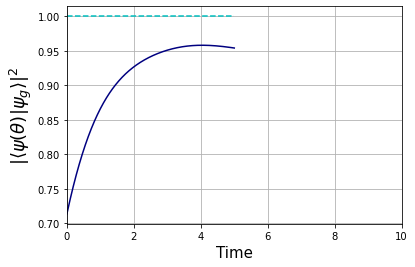

In [154]:
n = 1
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(1):
    plt.plot(time_domain,expt_value[kkk], color = colors[kkk])
plt.plot(time_domain,1.*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$|\langle \psi(\theta)|\psi_g\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
#plt.legend()
plt.xlim(0,10)
#plt.ylim(0.99,1)

#plt.savefig("Imaginary_time_evolution_fidelity_3qutrits_M=0.1_N=2_comparison.pdf")

No handles with labels found to put in legend.


(0.0, 10.0)

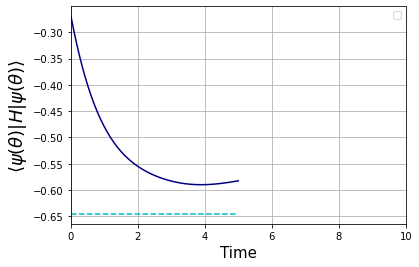

In [155]:
for kkk in range(1):
    plt.plot(time_domain,energyy[kkk], color = colors[kkk])
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="c")

plt.ylabel(r"$\langle \psi(\theta)|H|\psi(\theta)\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_comparison.pdf")

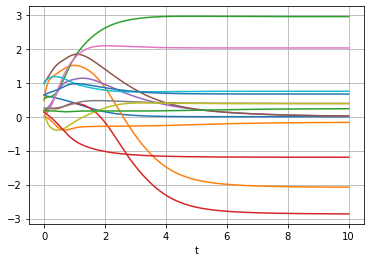

In [27]:
import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [28]:
for i in range(coeff*N):
    print(Y[-1][i])

-0.0009822630236511927
-2.0773526708935393
2.9480469499510007
-2.864729471160893
0.018013947434421584
0.018293766962629833
2.024719767673083
0.39156328242486227
0.38360063620482215
0.7497325366621957
0.6668533985677328
-0.1685353591678328
0.23401062171479337
-1.1941919452995613


In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

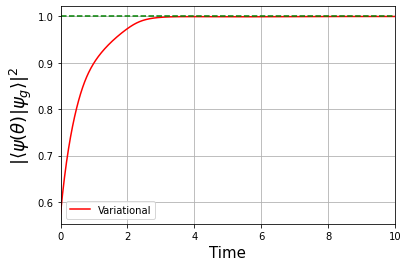

(0.0, 10.0)

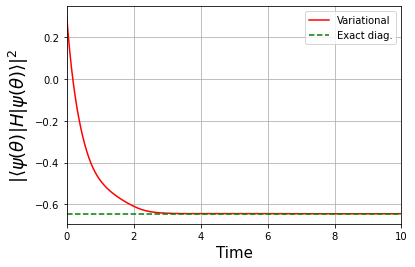

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
